<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/4.1-GRUB16-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer GRU with Balanced Weights using TensorFlow 2




In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
DRIVE_DIR = 'drive/My Drive/Springboard/capstone'
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/device:GPU:0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, \
                                    Dropout, Bidirectional, Embedding
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


from datetime import datetime


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import importlib
import json
import re

# custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.keras_util as ku
import util.file_util as fu
import util.report_util as ru

import random

# fix random seeds
RSTATE = 1
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)


logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()

import random

RSTATE = 1
# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)




# check to see if we are using GPU - must be placed at the beginning of the program
tf.debugging.set_log_device_placement(True)
print("GPU Available: ", tf.test.is_gpu_available())
print(f'Tensorflow Version: {tf.version.VERSION}')
print(f'Keras Version: {tf.keras.__version__}')


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False

REPORT_DIR = f'{DRIVE_DIR}/reports'

GRU_DIM = 16 # total GRU units
SAMPLES = "200k"


MODEL_NAME = f"GRU{GRU_DIM}"
ARCHITECTURE = f"1x{GRU_DIM}"
DESCRIPTION = r"1 Layer GRU ({GRU_DIM} units)"
FEATURE_SET_NAME = "random_embedding"
REPORT_FILE = "dl_prototype-report.csv"

if DEBUG:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test1k-preprocessed.csv"
  MODEL_NAME = f'test-{MODEL_NAME}'
  REPORT_FILE = f'test-{REPORT_FILE}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"

ku.ModelWrapper.set_report_filename(REPORT_FILE)

LEARNING_RATE = 0.01
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128
# from our previous notebook, we saw that 90% of our reviews have 100 or less
MAX_SEQUENCE_LENGTH = 100
PATIENCE = 4


start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available:  True
Tensorflow Version: 2.2.0-rc3
Keras Version: 2.3.0-tf


In [0]:

df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]



# Pre-process our data


In [4]:

X_train, X_test, y_train, y_test, tokenizer = \
                                  ku.preprocess_file(data_df=df, 
                                                      feature_column=FEATURE_COLUMN, 
                                                      label_column=LABEL_COLUMN, 
                                                     report_dir = REPORT_DIR,
                                                      max_sequence_length = MAX_SEQUENCE_LENGTH)

Vocabulary size=57430
Number of Documents=199538
Splitting data into training and test sets...
Training X type <class 'numpy.ndarray'> y type <class 'pandas.core.series.Series'>
Training X shape (149653, 100) y shape (149653,)
Test X shape (49885, 100) y shape (49885,)
Shape of y_train (149653,)
One hot enocde label data...


In [5]:
np.shape(X_train)

(149653, 100)

In [6]:
# Might have to play with this
vocab_size = len(tokenizer.word_counts)


# use functional syntax to create our graph
inp = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
# since we are using OOV - we have to add 2 since there is an extra index plus
# we add 1 according to documentation
x = Embedding(vocab_size + 2, EMBED_SIZE, trainable=True)(inp)
x = GRU(units=GRU_DIM, return_sequences=False)(x)
outp = Dense(5, activation='softmax')(x)

model = keras.models.Model(inputs=inp, outputs=outp)

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate = LEARNING_RATE), 
              metrics=['categorical_accuracy'])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          17229300  
_________________________________________________________________
gru (GRU)                    (None, 16)                15264     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 17,244,649
Trainable params: 17,244,649
Non-trainable params: 0
_________________________________________________________________


In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights = True)


early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1, 
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
weights_dict = {i: weights[i] for i in np.arange(0, len(weights))}
print(f'class weights: {weights}')
print(f'class weights_dict: {weights_dict}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME,
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN,
                     FEATURE_COLUMN,
                     DATA_FILE,
                     embed_size=EMBED_SIZE,
                     tokenizer=tokenizer,
                     description=DESCRIPTION)

history = mw.fit(X_train, 
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=1,
                validation_split=0.2,
                class_weight=weights_dict,
                callbacks=[early_stop, reduce_lr])

class weights: [1.43769724 3.07691596 2.18277088 1.19627098 0.37238702]
class weights_dict: {0: 1.4376972404351898, 1: 3.076915959907479, 2: 2.182770880052508, 3: 1.1962709832134293, 4: 0.372387022124348}
Number of training examples: 149653
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:

Number of test: 49885
Running model.evaluate...
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_18728

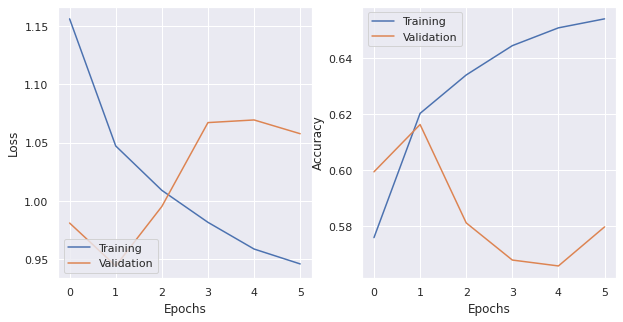


Confusion Matrix
[[ 4775  1110   713   180   180]
 [ 1146   836   875   237   139]
 [  559   718  1858  1057   362]
 [  239   290  1524  3383  2932]
 [  577   299  1153  4800 19943]]

Classification Report
              precision    recall  f1-score   support

           1       0.65      0.69      0.67      6958
           2       0.26      0.26      0.26      3233
           3       0.30      0.41      0.35      4554
           4       0.35      0.40      0.38      8368
           5       0.85      0.74      0.79     26772

    accuracy                           0.62     49885
   macro avg       0.48      0.50      0.49     49885
weighted avg       0.65      0.62      0.63     49885



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

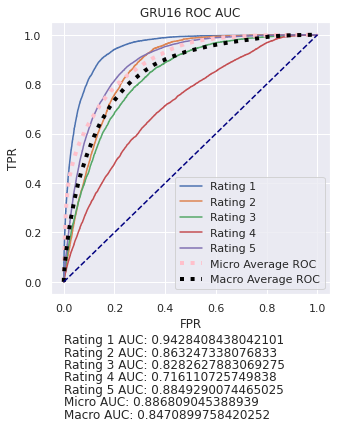

In [9]:
importlib.reload(pu)

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))



pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [10]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.43744031438362196


# Save off files so we can load later

In [11]:
mw.save(DRIVE_DIR, append_report=True)


description: GRU16-1x16-random_embedding-sampling_none-199538-100-review_body
Saving to report file: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
{'model_name': 'GRU16', 'architecture': '1x16', 'description': '1 Layer GRU ({GRU_DIM} units)', 'feature_column': '{"1": {"precision": 0.6544682017543859, "recall": 0.6862604196608221, "f1-score": 0.669987371965764, "support": 6958}, "2": {"precision": 0.2569935444205349, "recall": 0.2585833591091865, "f1-score": 0.2577860006167129, "support": 3233}, "3": {"precision": 0.30344602319124614, "recall": 0.40799297321036454, "f1-score": 0.3480378383441042, "support": 4554}, "4": {"precision": 0.35031583307445374, "recall": 0.40427820267686426, "f1-score": 0.3753675450762829, "support": 8368}, "5": {"precision": 0.8466208184751232, "recall": 0.7449200657403258, "f1-score": 0.7925210618343665, "support": 26772}, "accuracy": 0.617319835621

In [12]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /jo

In [13]:
end_time = datetime.now()
print(f'Start Time: {start_time}\n' \
      f'End Time: {end_time}\n' \
      f'Total Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins')
print(datetime.now())

Start Time: 2020-05-02 12:14:38.905667
End Time: 2020-05-02 12:31:21.317993
Total Duration: 16.71 mins
2020-05-02 12:31:21.318657
